In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

# Fine tune yolov8n

In [ ]:
!pip install ultralytics


In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="dHs1zwg6bZ079Id3qUJD")
project = rf.workspace("vkr-final").project("traffic-signs-classification-vmxtz")
version = project.version(1)
dataset = version.download("yolov8", location="/content/drive/MyDrive/TrafficSignsDataset")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/drive/MyDrive/TrafficSignsDataset in yolov8:: 100%|██████████| 13982/13982 [01:53<00:00, 123.33it/s]


In [ ]:
model = YOLO("yolov8n.pt")

results = model.train(
    data="/content/drive/MyDrive/TrafficSignsDataset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="yolov8n_traffic_signs_finetune_v2",
    device=0,
    workers=4,
    patience=10,
    project="/content/yolo_results",
    pretrained=True
)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/TrafficSignsDataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_traffic_signs_finetune_v2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

In [ ]:
!pip install ultralytics pillow-heif --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.7 MB/s eta 0:00:00


🚀 Using device: cuda
✅ YOLO model loaded from: /content/yolo_results/yolov8n_traffic_signs_finetune_v2/weights/best.pt
✅ MobileNetV2 model loaded.
📂 Loaded existing DB with 44 embeddings.

📤 Upload images to detect and match with DB


Saving cac-loai-bien-bao-gioi-han-toc-do-toi-da-va-toi-thieu-536092.jpg to cac-loai-bien-bao-gioi-han-toc-do-toi-da-va-toi-thieu-536092 (9).jpg

📁 Processing: cac-loai-bien-bao-gioi-han-toc-do-toi-da-va-toi-thieu-536092 (9).jpg

0: 384x640 1 2, 1 5, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
📸 Detected 2 objects in cac-loai-bien-bao-gioi-han-toc-do-toi-da-va-toi-thieu-536092 (9).jpg
🔹 Object 1: 2 (0.83)
🔹 Object 2: 5 (0.84)


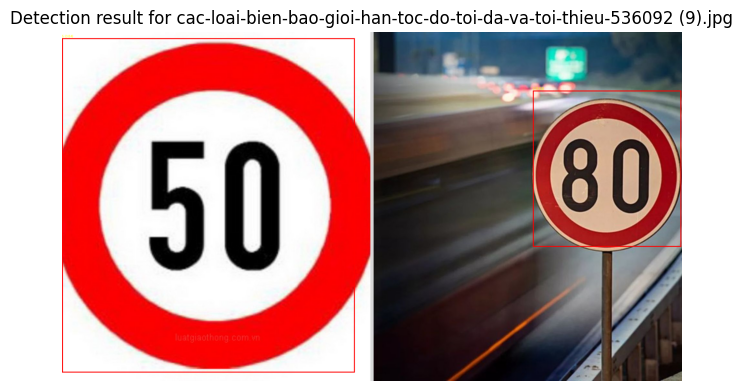

In [ ]:
import torch
from torchvision import models, transforms
from torchvision.models import MobileNet_V2_Weights
from PIL import Image, ImageDraw, ImageFont, UnidentifiedImageError
import io
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pillow_heif import register_heif_opener
from google.colab import files

register_heif_opener()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")
=
yolo_weight_path = "/content/yolo_results/yolov8n_traffic_signs_finetune_v2/weights/best.pt"
yolo_model = YOLO(yolo_weight_path)
yolo_model.to(device)
print(f"YOLO model loaded from: {yolo_weight_path}")

mobilenet = models.mobilenet_v2(weights=None)
mobilenet.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    torch.nn.Linear(1280, 43)
)
mobilenet.load_state_dict(torch.load(
    "/content/drive/MyDrive/nhandangmau/weight/mobilenetv2_test.pth",
    map_location=device
))
mobilenet.to(device)
mobilenet.eval()
print("MobileNetV2 model loaded.")

class MobileNetEmbedding(torch.nn.Module):
    def __init__(self, trained_model):
        super().__init__()
        self.features = trained_model.features
        self.pool = torch.nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return x

embedding_model = MobileNetEmbedding(mobilenet).to(device)
embedding_model.eval()

weights = MobileNet_V2_Weights.IMAGENET1K_V1
tf_mobilenet = transforms.Compose([
    transforms.Resize((224, 224)),
    weights.transforms()
])

db_path = "/content/drive/MyDrive/nhandangmau/db_embeddings.npy"
if os.path.exists(db_path):
    db = np.load(db_path, allow_pickle=True).item()
    print(f"📂 Loaded existing DB with {len(db)} embeddings.")
else:
    db = {}
    print("📂 No DB found. Creating new one.")

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def match_embedding(query_vec, db):
    if not db:
        return None, 0
    names = list(db.keys())
    vectors = np.array(list(db.values()))
    sims = np.array([cosine_similarity(query_vec, v) for v in vectors])
    best_idx = np.argmax(sims)
    return names[best_idx], sims[best_idx]

print("\n📤 Upload images to detect and match with DB")
uploaded = files.upload()

SUPPORTED_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif", ".tiff", ".jfif", ".webp", ".ico", ".heic")

for fn, content in uploaded.items():
    ext = os.path.splitext(fn)[1].lower()
    print(f"\n📁 Processing: {fn}")

    if ext not in SUPPORTED_EXTS:
        print(f"⚠️ Unsupported extension '{ext}'. Trying to open as image anyway...")

    try:
        img = Image.open(io.BytesIO(content)).convert("RGB")
    except UnidentifiedImageError:
        print(f"❌ Error: {fn} is not a valid image or unsupported format.")
        continue
    except Exception as e:
        print(f"❌ Failed to load {fn}: {e}")
        continue


    results = yolo_model(img)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    cls_ids = results[0].boxes.cls.cpu().numpy().astype(int)
    names = results[0].names
    print(f"📸 Detected {len(boxes)} objects in {fn}")

    draw = ImageDraw.Draw(img)

    for i, (box, cls_id) in enumerate(zip(boxes, cls_ids)):
        xmin, ymin, xmax, ymax = [int(b) for b in box]
        crop = img.crop((xmin, ymin, xmax, ymax))

        x = tf_mobilenet(crop).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = embedding_model(x).cpu().numpy()[0]

        best_name, score = match_embedding(emb, db)
        class_name = names[cls_id] if names and cls_id in names else f"cls_{cls_id}"
        label = f"{class_name} ({score:.2f})" if best_name else class_name

        print(f"🔹 Object {i+1}: {label}")
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
        font = ImageFont.load_default()
        text_y = ymin - 12 if ymin > 12 else ymin + 5
        draw.text((xmin, text_y), label, fill="yellow", font=font)


    plt.figure(figsize=(8, 8))

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Detection result for {fn}")
    plt.show()
